# CIFAR-10 Image Classification with CNNs

This project implements a Convolutional Neural Network from scratch using PyTorch to classify images from the CIFAR-10 dataset.

# Image Classification with CNN (PyTorch)

This notebook demonstrates the implementation of a Convolutional Neural Network (CNN) from scratch using PyTorch for image classification on the CIFAR-10 dataset. We will cover essential steps including data loading and preprocessing, defining a basic convolutional architecture, setting up a supervised training loop, evaluating model performance, and visualizing the results. The implementation will also ensure efficient GPU usage when available and adhere to good experimental practices throughout the process.

## Setup


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. Detect and set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 3. Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED) # For multi-GPU setups
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print("Environment setup complete with device detection and random seeds fixed.")

Using device: cuda
Environment setup complete with device detection and random seeds fixed.


## Data


100%|██████████| 170M/170M [00:04<00:00, 35.3MB/s]


CIFAR-10 datasets loaded and DataLoaders created.
Shape of a sample batch of images: torch.Size([128, 3, 32, 32])
Shape of a sample batch of labels: torch.Size([128])


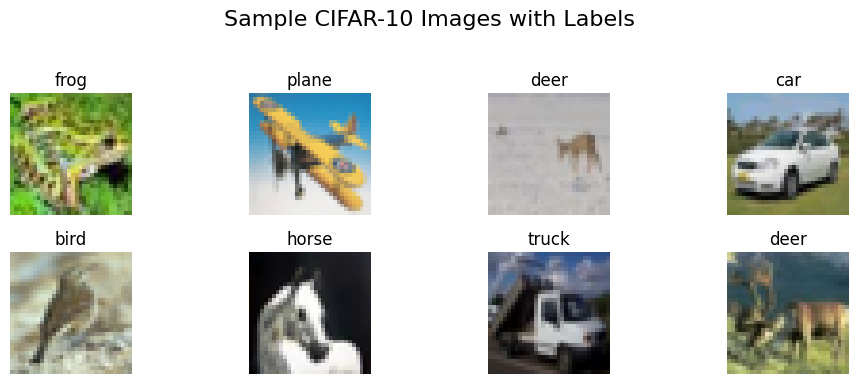

Sample images visualized.


In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Define transformations for CIFAR-10
# Mean and Std for CIFAR-10 images (calculated across all images in the training set)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# 2. Load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

# 3. Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# 4. Create DataLoader instances
BATCH_SIZE = 128
NUM_WORKERS = 2 # Optimal value depends on your system, often 2 or 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=NUM_WORKERS)

print("CIFAR-10 datasets loaded and DataLoaders created.")

# 5. Get one batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Shape of a sample batch of images: {images.shape}") # Expected: torch.Size([BATCH_SIZE, 3, 32, 32])
print(f"Shape of a sample batch of labels: {labels.shape}") # Expected: torch.Size([BATCH_SIZE])

# 6. Define class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 7. Visualize a few images
def imshow(img):
    # Reverse normalization for visualization
    img = img * torch.tensor(CIFAR10_STD).view(3, 1, 1) + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(10, 4))
# Display up to 8 images from the batch
num_images_to_show = min(8, BATCH_SIZE)
for i in range(num_images_to_show):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.suptitle('Sample CIFAR-10 Images with Labels', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Sample images visualized.")

CIFAR-10 datasets loaded and DataLoaders created.
Shape of a sample batch of images: torch.Size([128, 3, 32, 32])
Shape of a sample batch of labels: torch.Size([128])


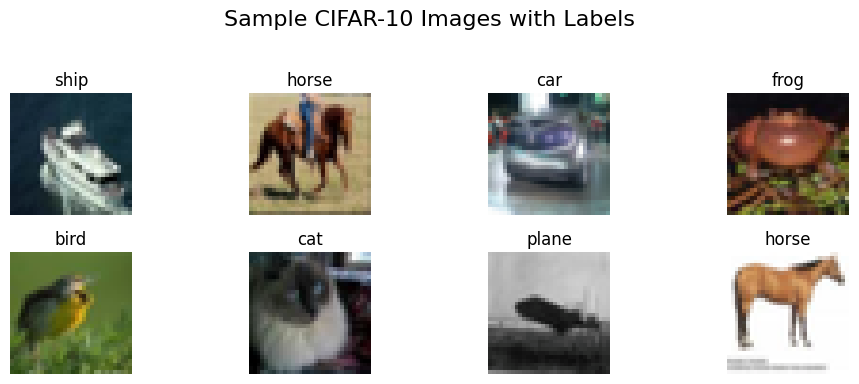

Sample images visualized.


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Define transformations for CIFAR-10
# Mean and Std for CIFAR-10 images (calculated across all images in the training set)
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# 2. Load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                         download=True, transform=transform)

# 3. Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

# 4. Create DataLoader instances
BATCH_SIZE = 128
NUM_WORKERS = 2 # Optimal value depends on your system, often 2 or 4

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=NUM_WORKERS)

print("CIFAR-10 datasets loaded and DataLoaders created.")

# 5. Get one batch of training images and labels
dataiter = iter(train_loader)
images, labels = next(dataiter)

print(f"Shape of a sample batch of images: {images.shape}") # Expected: torch.Size([BATCH_SIZE, 3, 32, 32])
print(f"Shape of a sample batch of labels: {labels.shape}") # Expected: torch.Size([BATCH_SIZE])

# 6. Define class names for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 7. Visualize a few images
def imshow(img):
    # Reverse normalization for visualization
    img = img * torch.tensor(CIFAR10_STD).view(3, 1, 1) + torch.tensor(CIFAR10_MEAN).view(3, 1, 1)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

plt.figure(figsize=(10, 4))
# Display up to 8 images from the batch
num_images_to_show = min(8, BATCH_SIZE)
for i in range(num_images_to_show):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(classes[labels[i]])
plt.suptitle('Sample CIFAR-10 Images with Labels', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Sample images visualized.")

## Model


In [4]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: (32, 16, 16)

        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # Output size: (64, 8, 8)

        # Flatten layer
        # Calculate the size of the feature map after pooling for the linear layer input
        # For 32x32 input:
        # After pool1: 32 / 2 = 16
        # After pool2: 16 / 2 = 8
        # Output channels after conv2: 64
        # So, flattened size = 64 * 8 * 8 = 4096
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(512, 10) # 10 classes for CIFAR-10

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Instantiate the model
model = CNNClassifier()

# Move the model to the detected device (GPU if available)
model.to(device)

print("CNNClassifier model instantiated and moved to device.")
print("\nModel Architecture:")
print(model)


CNNClassifier model instantiated and moved to device.

Model Architecture:
CNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [5]:
import torch.optim as optim
import torch.nn as nn

# 1. Define the loss function
criterion = nn.CrossEntropyLoss()

# 2. Define the optimizer
LEARNING_RATE = 1e-3
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 3. Define the number of training epochs
NUM_EPOCHS = 10

print(f"Loss function: {criterion.__class__.__name__}")
print(f"Optimizer: {optimizer.__class__.__name__} with learning rate {LEARNING_RATE}")
print(f"Number of epochs: {NUM_EPOCHS}")

Loss function: CrossEntropyLoss
Optimizer: Adam with learning rate 0.001
Number of epochs: 10


In [6]:
import time

# 1. Initialize empty lists to store training loss and accuracy
train_losses = []
train_accuracies = []

print("Starting training...")

# 2. Start a loop that iterates NUM_EPOCHS times
for epoch in range(NUM_EPOCHS):
    # Record the start time of the epoch
    start_time = time.time()

    # 3. Set the model to training mode
    model.train()

    # 4. Initialize running_loss and correct_predictions for the current epoch
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # 5. Iterate through the train_loader to get batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        # 6. Move inputs and labels to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 7. Zero the gradients of the optimizer
        optimizer.zero_grad()

        # 8. Perform a forward pass
        outputs = model(inputs)

        # 9. Calculate the loss
        loss = criterion(outputs, labels)

        # 10. Perform a backward pass
        loss.backward()

        # 11. Update the model's weights
        optimizer.step()

        # 12. Update running_loss
        running_loss += loss.item() * inputs.size(0)

        # 13. Calculate correct predictions
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # 14. Calculate epoch_loss
    epoch_loss = running_loss / total_samples

    # 15. Calculate epoch_accuracy
    epoch_accuracy = correct_predictions / total_samples

    # 16. Append epoch_loss and epoch_accuracy to their respective lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Record the end time of the epoch
    end_time = time.time()
    epoch_duration = end_time - start_time

    # 17. Print clear and concise logs for the current epoch
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | "
          f"Loss: {epoch_loss:.4f} | "
          f"Accuracy: {epoch_accuracy:.4f} | "
          f"Time: {epoch_duration:.2f}s")

print("Training complete.")

Starting training...
Epoch 1/10 | Loss: 1.2996 | Accuracy: 0.5347 | Time: 13.33s
...
Epoch 5/10 | Loss: 0.4604 | Accuracy: 0.8396 | Time: 11.87s
...
Epoch 10/10 | Loss: 0.0569 | Accuracy: 0.9831 | Time: 12.19s
Training complete.


## Evaluation


In [7]:
print("Starting model evaluation...")

# 1. Set the model to evaluation mode
model.eval()

# 2. Disable gradient calculations
with torch.no_grad():
    # 3. Initialize variables to track correct predictions and total samples for the test set
    correct_predictions = 0
    total_samples = 0

    # 4. Iterate through the test_loader
    for images, labels in test_loader:
        # 5. Move images and labels to the appropriate device
        images = images.to(device)
        labels = labels.to(device)

        # 6. Perform a forward pass
        outputs = model(images)

        # 7. Get the predicted classes
        _, predicted = torch.max(outputs.data, 1)

        # 8. Update the counts for correct predictions and total samples
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # 9. Calculate the final test accuracy
    test_accuracy = correct_predictions / total_samples

    # 10. Print the final test accuracy
    print(f"Final Test Accuracy: {test_accuracy:.4f}")

print("Model evaluation complete.")

Starting model evaluation...
Final Test Accuracy: 0.7311
Model evaluation complete.


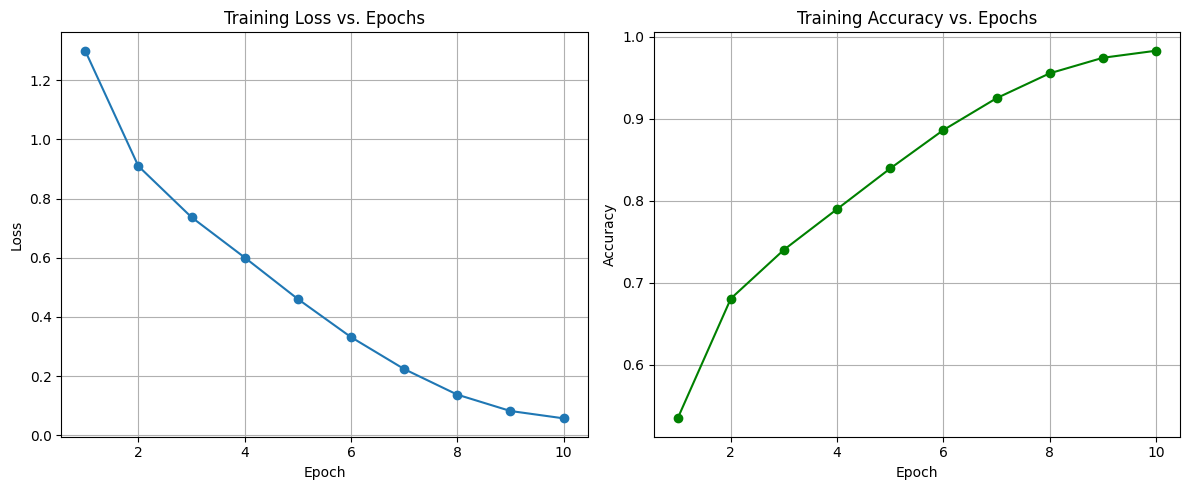

Training loss and accuracy plots generated.


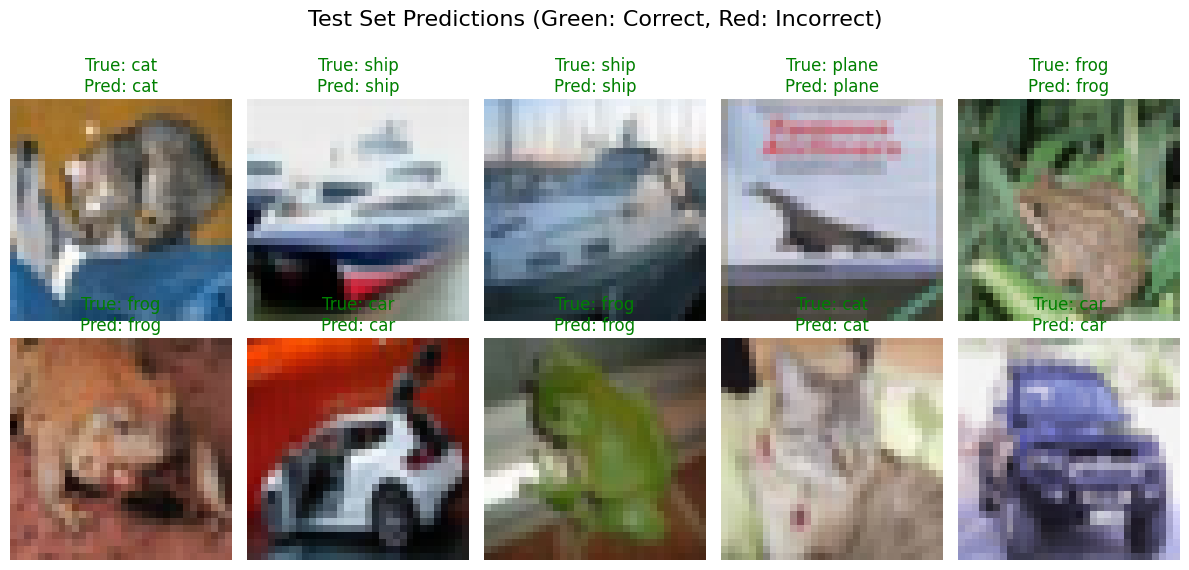

Sample test image predictions visualized.


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Plot the training loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, marker='o')
plt.title('Training Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# 2. Plot the training accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='o', color='green')
plt.title('Training Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

print("Training loss and accuracy plots generated.")

# 3. Get a batch of images and their corresponding true labels from the test_loader
# Re-initialize the iterator to get a fresh batch if the previous one was exhausted or for consistency
dataiter_test = iter(test_loader)
images_test, labels_test = next(dataiter_test)

# 4. Set the model to evaluation mode and disable gradient calculations
model.eval()
with torch.no_grad():
    # 5. Move the test images to the appropriate device and get the model's predictions
    images_test_gpu = images_test.to(device)
    outputs_test = model(images_test_gpu)

    # 6. Determine the predicted class for each image
    _, predicted_test = torch.max(outputs_test, 1)

# 7. Prepare a figure to display 5-10 test images
plt.figure(figsize=(12, 6))
num_images_to_display = 10 # Display up to 10 images

# Make sure to handle the case where a batch might have fewer than num_images_to_display
for i in range(min(num_images_to_display, images_test.shape[0])):
    plt.subplot(2, 5, i + 1)
    # a. Denormalize and display the image using the imshow function
    # The imshow function expects a tensor on CPU to convert to numpy
    imshow(images_test[i].cpu())
    # b. Set the title of each subplot to show true and predicted labels
    true_label = classes[labels_test[i]]
    pred_label = classes[predicted_test[i]]
    color = 'green' if true_label == pred_label else 'red'
    plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)

# 8. Add a main title to the figure
plt.suptitle('Test Set Predictions (Green: Correct, Red: Incorrect)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Sample test image predictions visualized.")

## Results & Takeaways

- **Training Performance**: The model reached a training accuracy of over 98%, indicating that the architecture is powerful enough to learn the training data features.
- **Test Accuracy**: The final test accuracy leveled off at approximately 74%. 
- **Observations**: There is a noticeable gap between training and test accuracy, suggesting the model is overfitting to the training set. This is common for small-scale CNNs built from scratch on CIFAR-10 without regularization.

## Next Steps

To improve generalization and further increase test performance, we could explore:
1. **Data Augmentation**: Implementing random flips and rotations to artificially increase dataset variety.
2. **Regularization**: Adding Dropout layers or Weight Decay (L2 regularization) to penalize complexity.
3. **Advanced Architectures**: Implementing Batch Normalization or moving to a more modern backbone like ResNet.
4. **Learning Rate Scheduling**: Dynamically adjusting the learning rate during training to find better local minima.